In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/SUTD/Term_7_ AI_healthcare/Problem_Set_2

/content/drive/MyDrive/SUTD/Term_7_ AI_healthcare/Problem_Set_2


In [3]:
import pandas as pd
import numpy as np
import os,sys
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential

In [5]:
#Parameters
!ls

'01_116_Healthcare_and_AI_Lab_2__Time_based_prediction (1).pdf'
 Assignment_2-Student_version.ipynb
 data_sets
 HDeviceCGM.csv


# Understanding the data

In [6]:
df=pd.read_csv("HDeviceCGM.csv")
window_size=10
df.head(10)

,RecID,ParentHDeviceUploadsID,PtID,SiteID,DeviceDtTmDaysFromEnroll,DeviceTm,DexInternalDtTmDaysFromEnroll,DexInternalTm,RecordType,GlucoseValue
0,15047224,4110,14,9,6,10:56:34,6,18:56:35,CGM,76
1,15047225,4110,14,9,6,10:51:34,6,18:51:35,CGM,75
2,15047226,4110,14,9,6,10:46:34,6,18:46:35,CGM,74
3,15047227,4110,14,9,6,10:41:34,6,18:41:35,CGM,72
4,15047228,4110,14,9,6,10:36:34,6,18:36:35,CGM,71
5,15047229,4110,14,9,6,10:31:34,6,18:31:35,CGM,67
6,15047230,4110,14,9,6,10:26:34,6,18:26:35,CGM,64
7,15047231,4110,14,9,6,10:21:34,6,18:21:35,CGM,60
8,15047232,4110,14,9,6,10:16:34,6,18:16:35,CGM,57
9,15047233,4110,14,9,6,10:11:34,6,18:11:35,CGM,55


Checkpoint1:Study the training data-set and answer the following 
    1) How many sets of continuous training data sets do you have available 
    2) Thecount of samples points per training data sets. Segments the data-sets into training and testing.

In [8]:
s1 = '10:33:26'
s2 = '11:15:49' # for example
FMT = '%H:%M:%S'
start=0
data_sets_number=1
data_sets_count={}
for i in range(len(df["DeviceTm"])-2):
    s1=df["DeviceTm"][i]
    s2=df["DeviceTm"][i+1]
    device_check= df["DeviceDtTmDaysFromEnroll"][i]!=df["DeviceDtTmDaysFromEnroll"][i+1]
    tdelta = datetime.strptime(s1, FMT) - datetime.strptime(s2, FMT)
    if (tdelta.seconds//60)%60 > 15 and device_check: # if the time difference is more than 15 minutes and devices and change number
        if i-start >window_size: # The window size that we want to set is 4, thus entries less than 4 to be removed
            data_sets_count[data_sets_number]=i+1-start
            df_new=df.iloc[start:i][["DeviceTm","GlucoseValue"]]
            df_new.to_csv("./data_sets/{}.csv".format(data_sets_number))
            data_sets_number+=1
            start= i+1
        

In [9]:
print("The number of sets of " ,data_sets_number)

The number of sets of  50


In [10]:
print("The number of sample points in each sets" )
values=[]
for sets in data_sets_count:
    print(" Sets : {}   Count :   {}".format(sets, data_sets_count[sets]))
    if data_sets_count[sets] <window_size:
        pass
#         del data_sets_count[sets]
    else:
        values.append(data_sets_count[sets])
#         print(" Sets : {}   Count :   {}".format(sets, data_sets_count[sets]))
        

The number of sample points in each sets
 Sets : 1   Count :   85
 Sets : 2   Count :   36
 Sets : 3   Count :   60
 Sets : 4   Count :   72
 Sets : 5   Count :   22
 Sets : 6   Count :   49
 Sets : 7   Count :   31
 Sets : 8   Count :   26
 Sets : 9   Count :   115
 Sets : 10   Count :   47
 Sets : 11   Count :   57
 Sets : 12   Count :   39
 Sets : 13   Count :   32
 Sets : 14   Count :   13
 Sets : 15   Count :   12
 Sets : 16   Count :   15
 Sets : 17   Count :   13
 Sets : 18   Count :   20
 Sets : 19   Count :   57
 Sets : 20   Count :   73
 Sets : 21   Count :   25
 Sets : 22   Count :   115
 Sets : 23   Count :   67
 Sets : 24   Count :   89
 Sets : 25   Count :   19
 Sets : 26   Count :   132
 Sets : 27   Count :   111
 Sets : 28   Count :   96
 Sets : 29   Count :   96
 Sets : 30   Count :   15
 Sets : 31   Count :   22
 Sets : 32   Count :   83
 Sets : 33   Count :   77
 Sets : 34   Count :   99
 Sets : 35   Count :   160
 Sets : 36   Count :   32
 Sets : 37   Count :   19
 

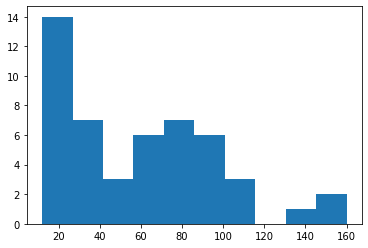

In [11]:
plt.hist(values ,bins=10)
plt.show()

# Data Pre-Processing

In [15]:

files =os.listdir("data_sets/")
input_matrix=[]
output_value=[]
max_value=max(df["GlucoseValue"])# use to normalize the input and output when training 
for file in files:
    df_new= pd.read_csv("data_sets/"+file)
    for i in range(len(df_new["GlucoseValue"])-window_size-1):
        input_matrix.append(df_new["GlucoseValue"][i:i+window_size].to_list())
#       
        output_value.append(df_new["GlucoseValue"][i+window_size+1])
#         break
def reshape(input_tensor):
    input_tensor=tf.convert_to_tensor(input_tensor)
    batch_shape,window_size= input_tensor.shape
    return tf.reshape(input_tensor, (batch_shape,1,window_size))/max_value


Checkpoint2:Display the dimensions for your pre-processed data and explain how it the window size is incorporated into this structure.

In [20]:
lstm =tf.keras.layers.LSTM(1)
ts=np.random.rand(10,4,4)
lstm(ts)

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.24771798],
       [0.22311133],
       [0.36030805],
       [0.22512025],
       [0.3332631 ],
       [0.2216226 ],
       [0.37777004],
       [0.18971881],
       [0.22563726],
       [0.3396676 ]], dtype=float32)>

In [51]:
input_train, input_test, output_train, output_test=train_test_split(input_matrix, output_value, test_size=0.20,shuffle=False)


In [52]:
input_train=reshape(input_train)
input_test=reshape(input_test)
output_train=tf.convert_to_tensor(output_train)/max_value
output_test=tf.convert_to_tensor(output_test)/max_value

In [53]:
datasets_train=tf.data.Dataset.from_tensor_slices((input_train, output_train))
datasets_test=tf.data.Dataset.from_tensor_slices((input_test, output_test)).batch(1)
datasets_input_train=tf.data.Dataset.from_tensor_slices(input_train).batch(40)
datasets_output_train=tf.data.Dataset.from_tensor_slices(output_train).batch(40)
data_batched= datasets_train.batch(40)
for i,j in data_batched:
    print(i.shape)
    print(j)
    break

(40, 1, 10)
tf.Tensor(
[0.6758794  0.68090452 0.69095477 0.6959799  0.6959799  0.69849246
 0.69849246 0.69849246 0.70100503 0.70351759 0.70100503 0.6959799
 0.69346734 0.27889447 0.29396985 0.30653266 0.31658291 0.32914573
 0.34170854 0.34673367 0.35427136 0.36180905 0.36934673 0.38693467
 0.40452261 0.4120603  0.41959799 0.42964824 0.44472362 0.45226131
 0.45477387 0.45226131 0.45477387 0.44221106 0.43969849 0.42462312
 0.41457286 0.40452261 0.39698492 0.3919598 ], shape=(40,), dtype=float64)


Explanation ： From the above you can see that the input shape is the form of (Batch_size, 1 input_dimension). This is because LSTM cells takes in 3 dimensional input， with the first dimension is the batch_size. and the second dimension will be used as 1 as our input has only one dimension. The Last dimension is the size of our input. 

# Modelling And training

Checkpoint 4: Select the correct Loss Function and optimiser and explain the reason for your choice

The loss function used Mean square Error. This loss function is able to penalize the the difference betweent the predicted and actual value by measuring the distance in between them.  It is less sensitive to outliers and erros in the data   

The optimizer used is Adam, Adam is normalized optimzier that use momentum and do elementwise optimization. This allows the optimizer to converge faster and more robust. 

In [87]:
model= Sequential([
    tf.keras.Input(shape=(1,window_size)),
    tf.keras.layers.LSTM(1),
    
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

Checkpoint 5: Graph and display the training loss of the model.

In [88]:
# model.build(input_shape=(3179,1,4))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 1)                 48        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


In [89]:
history1 =model.fit(data_batched, epochs=30)

Epoch 1/30
63/63 [==============================] - 2s 2ms/step - loss: 0.0209 - mse: 0.0209
Epoch 2/30
63/63 [==============================] - 0s 2ms/step - loss: 0.0031 - mse: 0.0031
Epoch 3/30
63/63 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 0.0023
Epoch 4/30
63/63 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 0.0019
Epoch 5/30
63/63 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016
Epoch 6/30
63/63 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 0.0015
Epoch 7/30
63/63 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 0.0014
Epoch 8/30
63/63 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 0.0013
Epoch 9/30
63/63 [==============================] - 0s 1ms/step - loss: 0.0013 - mse: 0.0013
Epoch 10/30
63/63 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012
Epoch 11/30
63/63 [==============================] - 0s 1ms/step - lo

# Validation

Checkpoint 6: Graph the remaining instances and plot them (Provide the
true data and the validated data on the same graph), display the mean loss for
each of the instance.

In [82]:
actual=[]
pred=[]
for i,j in datasets_test:    
    predict = model(i)
    actual.append(j[0]*max_value)
    pred.append(predict[0][0]*max_value)   

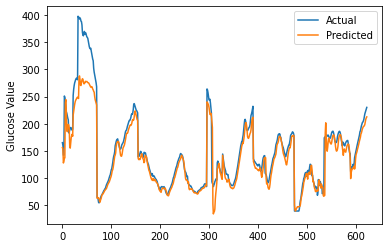

In [83]:
plt.plot(actual, label="Actual")
plt.plot(pred, label="Predicted")
plt.ylabel("Glucose Value")
plt.legend()
plt.show()

In [66]:
history1.history["loss"]

[0.009894848801195621,
 0.0038284657057374716,
 0.0032842871733009815,
 0.0028943198267370462,
 0.002539320383220911,
 0.0022312321234494448,
 0.002001112559810281,
 0.0018548014340922236,
 0.0017704892670735717,
 0.0017162153962999582,
 0.0016744459280744195,
 0.001638185465708375,
 0.0016050785779953003,
 0.0015744332922622561,
 0.0015460611321032047,
 0.0015198946930468082,
 0.001495877280831337,
 0.001473930082283914,
 0.0014539550757035613,
 0.0014358361950144172,
 0.001419442007318139,
 0.0014046349097043276,
 0.0013912725262343884,
 0.0013792142271995544,
 0.0013683221768587828,
 0.0013584691332653165,
 0.0013495334424078465,
 0.001341407187283039,
 0.0013339935103431344,
 0.0013272041687741876]

# Optimisation

Checkpoint 7: Write a short report presenting your analysis on the optimal hyper-parameter of choice. You may include the necessary graphs or printout to explain your optimal hyper-parameter of choice.

In the hyper parameter tuning, I have choosen normalized the input by its maximum value From the experiment below, you can see that without normalization, the loss is not able to converge, normalization is able to constraint the input within the range of 0 to 1.  \\
 The allows better convert of the the losses. I choose the learning rate to be started at 0.01. This allows the model to pick up the momentum in learning very quickly 

In [90]:
model2= Sequential([
    tf.keras.Input(shape=(1,window_size)),
    tf.keras.layers.LSTM(1),
    
])
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

In [85]:
history2 =model2.fit(data_batched, epochs=30)

Epoch 1/30
63/63 [==============================] - 2s 1ms/step - loss: 0.1785 - mse: 0.1785
Epoch 2/30
63/63 [==============================] - 0s 1ms/step - loss: 0.0272 - mse: 0.0272
Epoch 3/30
63/63 [==============================] - 0s 2ms/step - loss: 0.0070 - mse: 0.0070
Epoch 4/30
63/63 [==============================] - 0s 1ms/step - loss: 0.0056 - mse: 0.0056
Epoch 5/30
63/63 [==============================] - 0s 2ms/step - loss: 0.0045 - mse: 0.0045
Epoch 6/30
63/63 [==============================] - 0s 1ms/step - loss: 0.0039 - mse: 0.0039
Epoch 7/30
63/63 [==============================] - 0s 1ms/step - loss: 0.0034 - mse: 0.0034
Epoch 8/30
63/63 [==============================] - 0s 1ms/step - loss: 0.0031 - mse: 0.0031
Epoch 9/30
63/63 [==============================] - 0s 1ms/step - loss: 0.0028 - mse: 0.0028
Epoch 10/30
63/63 [==============================] - 0s 2ms/step - loss: 0.0026 - mse: 0.0026
Epoch 11/30
63/63 [==============================] - 0s 1ms/step - lo

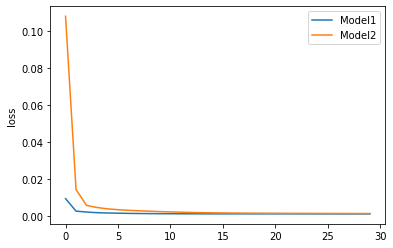

In [91]:
plt.plot(history1.history["loss"], label="Model1")
plt.plot(history2.history["loss"], label="Model2")
plt.legend()
plt.ylabel("loss")
plt.show()

In [100]:
input_train, input_test, output_train, output_test=train_test_split(input_matrix, output_value, test_size=0.20,shuffle=False)
max_value=1
input_train=reshape(input_train)
input_test=reshape(input_test)
output_train=tf.convert_to_tensor(output_train)/max_value
output_test=tf.convert_to_tensor(output_test)/max_value
datasets_train_t=tf.data.Dataset.from_tensor_slices((input_train, output_train)).batch(40)
datasets_test_t=tf.data.Dataset.from_tensor_slices((input_test, output_test)).batch(1)

In [103]:
model3= Sequential([
    tf.keras.Input(shape=(1,window_size)),
    tf.keras.layers.LSTM(1),
    
])
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

In [104]:
history3 =model3.fit(datasets_train, epochs=30)

Epoch 1/30
63/63 [==============================] - 2s 1ms/step - loss: 21101.0568 - mse: 21101.0568
Epoch 2/30
63/63 [==============================] - 0s 1ms/step - loss: 21101.0568 - mse: 21101.0568
Epoch 3/30
63/63 [==============================] - 0s 2ms/step - loss: 21101.0568 - mse: 21101.0568
Epoch 4/30
63/63 [==============================] - 0s 1ms/step - loss: 21101.0568 - mse: 21101.0568
Epoch 5/30
63/63 [==============================] - 0s 2ms/step - loss: 21101.0568 - mse: 21101.0568
Epoch 6/30
63/63 [==============================] - 0s 1ms/step - loss: 21101.0568 - mse: 21101.0568
Epoch 7/30
63/63 [==============================] - 0s 1ms/step - loss: 21101.0568 - mse: 21101.0568
Epoch 8/30
63/63 [==============================] - 0s 2ms/step - loss: 21101.0568 - mse: 21101.0568
Epoch 9/30
63/63 [==============================] - 0s 2ms/step - loss: 21101.0568 - mse: 21101.0568
Epoch 10/30
63/63 [==============================] - 0s 2ms/step - loss: 21101.0568 - mse: 

In [105]:
actual=[]
pred=[]
for i,j in datasets_test:    
    predict = model(i)
    actual.append(j[0]*max_value)
    pred.append(predict[0][0]*max_value)   

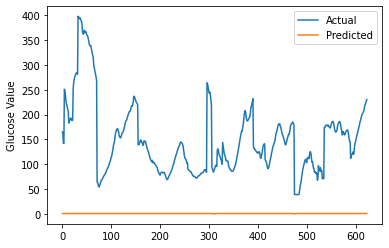

In [106]:
plt.plot(actual, label="Actual")
plt.plot(pred, label="Predicted")
plt.ylabel("Glucose Value")
plt.legend()
plt.show()